# RSA experiment overview

This document consists of an overview of the experiments that will be done to shed more light on the effect of different initializations on the structure of emerging languages. In order to give a complete image of the effect on the structure, the research will consists of three parts. These three parts will be further clarified in this document, along with some results to back them up. 

The first part will consist of a hyperparameter search. We take the same setup and initialize it 10 different times using different seeds. 

The second part will utilize a mapping network. This mapping network will act as a translation machine. We will try to find whether differently intialized agents will keep the same structure in their language by 

The third part will consist of an experiment showing to what extent differently initialized agents are able to generalize. 

More information as to how and why we conduct these experiments will be added to the subsections.

## -----------------------------------------------------------------------------------------------------------------------------

## Plot code

In [1]:
import glob
import scipy.stats
import numpy as np
import pickle
import os

from itertools import combinations
from scipy import spatial
from metrics import rsa
from data import one_hot
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

baseline_path = 'runs/lstm_max_len_10_vocab_25_attr_5'

In [2]:
def get_run_name(run:str)->str:
    if run == 'lstm_max_len_10_vocab_25_attr_5':
        return 'baseline'
    else:
        return run
    
def plot_metric(results, metric="loss", run='baseline', ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    generations = []
    values = []
    run_names = []
    
    for r in list(results.keys()):
        # LET OP, HIER CHECKEN WE OP HET MOMENT ALLEEN DE BASELINE
        if r == 'baseline':
            for s in list(results[r].keys()):    
                for g in sorted(list(results[r][s].keys())):
                    generations.append(g)
                    values.append(results[r][s][g][metric])
                    run_names.append(r)
            
    values = np.array(values)
    iterations = np.array(generations)   
    
    # voeg hier metrics toe
    d = {'Iterations': iterations,'': run_names, metric: values}
    ax = sns.lineplot(ax=ax, x='Iterations', y=metric, data=pd.DataFrame(data=d))

    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()
    
def plot_all_metric(results, metric="loss", runs="all", ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
        
    run_names = []
    all_values = []
    all_iterations = []
    
    for r in list(results.keys()):
        # check which run the user would like to see
        if r == runs or runs=="all":
            
            values = []
            generations = []
            for s in list(results[r].keys()):    
                for g in sorted(list(results[r][s].keys())):
                    generations.append(g)
                    values.append(results[r][s][g][metric])
                    #run_names.append(r)

            values = np.array(values)
            iterations = np.array(generations) 
            all_values.append(values)
            all_iterations.append(iterations)

    # initialize data dictionary
    d = {}
    
    # fill dictionary with rest of data
    for i, key in enumerate(results.keys()):
        if key == runs or runs=="all":
            d[key] = all_values[i]  
            d['Iterations'] = all_iterations[i]
    data_preproc=pd.DataFrame(data=d)

    # plot data
    ax = sns.lineplot(x='Iterations', y=metric, hue='method', 
                      data=pd.melt(data_preproc, ['Iterations'],
                                   var_name='method',
                                   value_name=metric))
    
    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()
    
def plot_rsa_metric(results, metric, ylabel=None, show_error=True, 
                    savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27), show=True):
    
    # initialize plots
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    # get data to fill up plot
    all_values = []
    for result in results.values():

        generations = []
        values = []
        run_names = []

        for s in list(result[metric].keys()):    
            for g in sorted(list(result[metric][s].keys())):
                generations.append(g)
                values.append(result[metric][s][g])
                run_names.append(metric)

        values = np.array(values)
        iterations = np.array(generations)   
        all_values.append(values)
    

    # initialize data dictionary
    d = {'Iterations': iterations}
        
    # fill dictionary with rest of data
    for i, key in enumerate(results.keys()):
        d[key] = all_values[i]    
    data_preproc=pd.DataFrame(data=d)

    ax = sns.lineplot(x='Iterations', y="RSA", hue='method', 
                      data=pd.melt(data_preproc, ['Iterations'],
                                   var_name='method',
                                   value_name="RSA"))

    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)

    plt.show()


In [3]:
# Loading metrics from saved pickles
metrics = {}
for m in glob.glob("runs/*/*/*.pkl"):
    run = m.split('/')[1]
    run_name = get_run_name(run)
    if run_name not in metrics:
        metrics[run_name] = {}
    seed = m.split('/')[2]
    if seed not in metrics[run_name]:
        metrics[run_name][seed]={}
        
    iteration = int(m.split('_')[-1].split('.')[0])
    metrics[run_name][seed][iteration] = pickle.load(open(m, 'rb'))

## -----------------------------------------------------------------------------------------------------------------------------

# Problem area

Let's start by pointing at the origin of the experiment. What finding actually causes us to think that agents converge to differently structured language, even when using completely the same architecture? The following plot shows RSA measures between message space for different languages. The setup was initialized using 10 different random seeds. This yields 10 different languages, for which RSA is measured on all possible combinations of languages. To measure RSA, we sample from each individual language. Distance measures will be used to find to what extent messages that describe different things differ in a language. This distance is thus calculated _within_ languages. Subsequenty, these distances will then be correlated _between_ languages. If language is structurally similar, we expect to find similar distances between messages that describe different objects. Correlation values should therefore be high on structurally similar language and low on dissimilar language.

/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


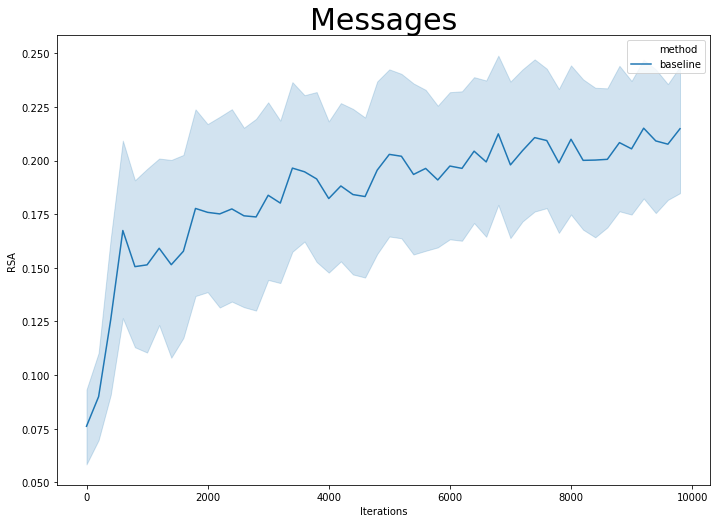

In [4]:
RSA_BASELINE = pickle.load(open(f'{baseline_path}/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {'baseline': RSA_BASELINE}

plot_rsa_metric(RSA_ANALYSIS, metric='ham_messages', title="Messages")


The results show that RSA values are quite low between languages (0.30~0.35). This indicates that the message spaces do not seem to be structurally similar to each other. Hence, we can conclude that agents converge to structurally different languages. If the agents where to converge to similar languages, the RSA values would be much higher. High RSA values would indicate that the languages are structurally similar to each other.


# Part 1: Hyperparameter search

As a first experiment, we will apply a hyperparameter search on the setup. The purpose of this experiment is to rule out the possibility that the initialization bias is caused by a certain hyperparameter or setup setting. The initialization bias means that agents converge to differently structured languages based on the values they are initialized on (the tricky part here is to decide when we have exhausted a hyperparameter or setup setting). Both hamming distance and Levenshtein distance will be used as distance measures between messages, to rule out the fact that the metric causes this bias to occur.

At first the effects of data shuffling will be measured. Secondly, the amount of attributes the agents have to describe will be altered. Thirdly, we will vary the environmental pressure by changing the vocabulary size and max length of the messages that can be created by the agents. 

## 1.1: Data shuffling
For this part, we initialize the dataloader with the same seed across all different initializations. The reason for doing so is to remove the possible effect created by the manner in which data is served into the model.

/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


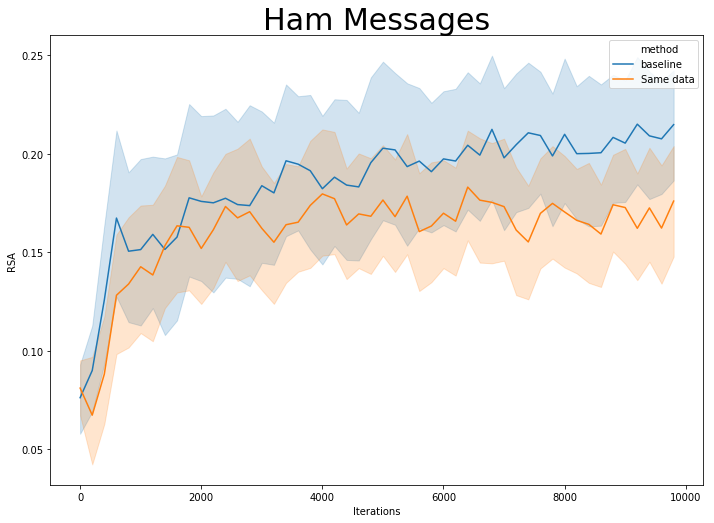

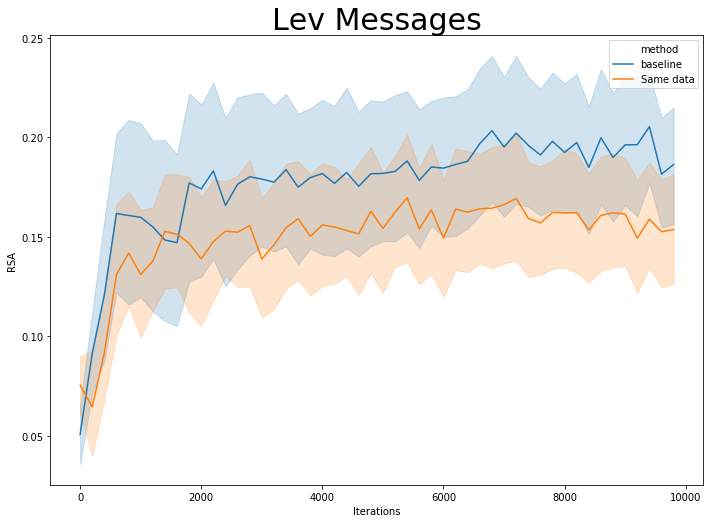

In [5]:
RSA_BASELINE = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_5/rsa_analysis.pkl', 'rb'))
RSA_SAME_DATA = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_same_data_attr_5/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {'baseline': RSA_BASELINE,
                'Same data': RSA_SAME_DATA}

for k in RSA_BASELINE:
    if k == "ham_messages" or k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)

In these plots, Ham Messages use the hamming distance metric and Lev Messages use the Levenshtein distance ratio to calculate the RSA.

It seems that the manner in which the data is shuffled does not alter the structure in the message that much. This might mean that the way of feeding data does not affect language emergence. 
Interesting finding, does it also occur on other environmental pressures or amount of attributes? What can we apply this on as well? 

## 1.2: Attributes

### Lower amounts of attributes

/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


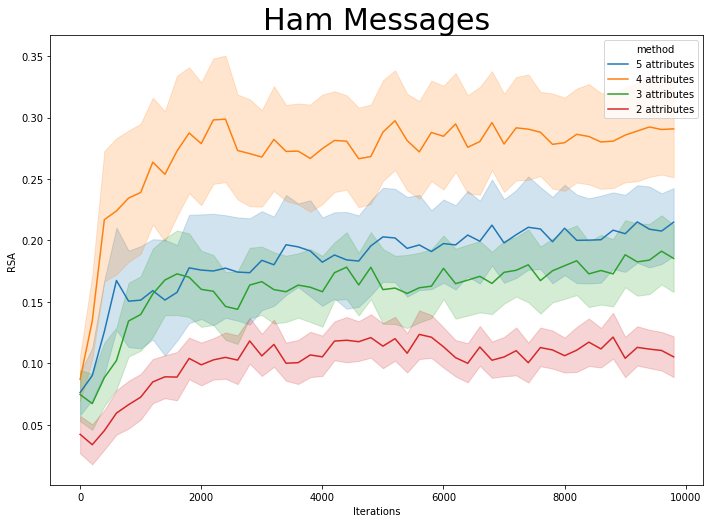

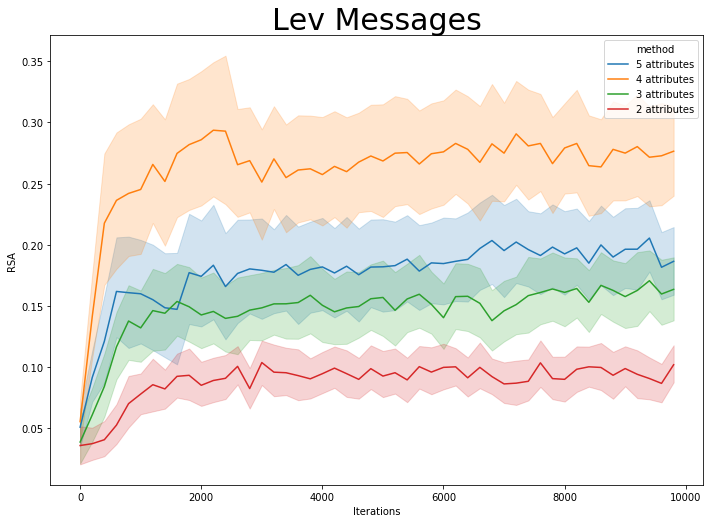

In [10]:
RSA_BASELINE = pickle.load(open(f'{baseline_path}/rsa_analysis.pkl', 'rb'))
RSA_4_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_4/rsa_analysis.pkl', 'rb'))
RSA_3_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_3/rsa_analysis.pkl', 'rb'))
RSA_2_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_2/rsa_analysis.pkl', 'rb'))
 

RSA_ANALYSIS = {'5 attributes': RSA_BASELINE,
                '4 attributes': RSA_4_ATTR,
                '3 attributes': RSA_3_ATTR,
                '2 attributes': RSA_2_ATTR,
               }

for k in RSA_BASELINE:
    if k == "ham_messages" or k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)

Besides the effect of the amount of attributes, this figure also shows the effect of dataset size. This is due to the fact that more attributes cause the dataset to grow exponentially (since we create a dataset of every possible combination). --> maybe sample 

### Higher amounts of attributes

/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


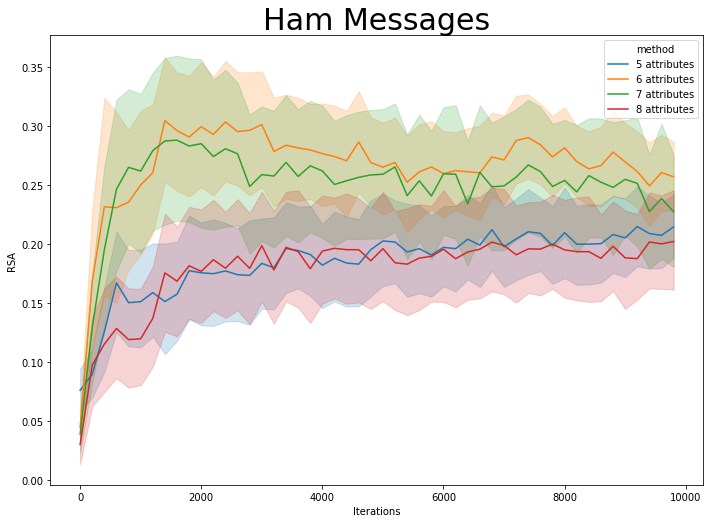

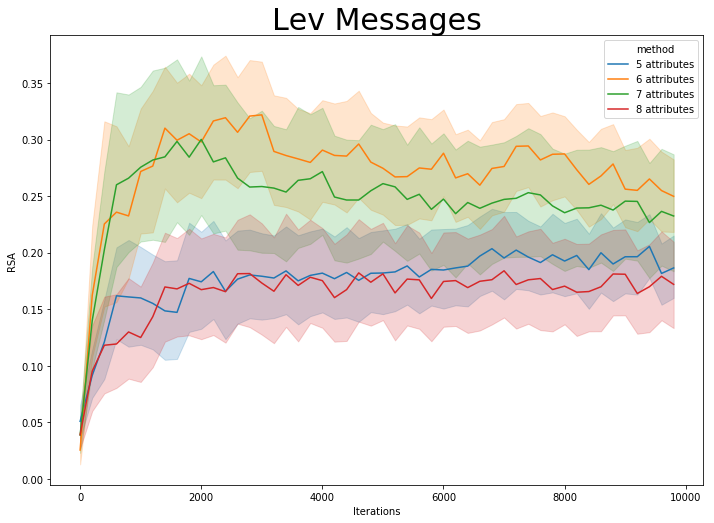

In [9]:
RSA_BASELINE = pickle.load(open(f'{baseline_path}/rsa_analysis.pkl', 'rb'))
RSA_6_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_6/rsa_analysis.pkl', 'rb'))
RSA_7_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_7/rsa_analysis.pkl', 'rb'))
RSA_8_ATTR = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_8/rsa_analysis.pkl', 'rb'))
 

RSA_ANALYSIS = {'5 attributes': RSA_BASELINE,
                '6 attributes': RSA_6_ATTR,
                '7 attributes': RSA_7_ATTR,
                '8 attributes': RSA_8_ATTR,
               }

for k in RSA_BASELINE:
    if k == "ham_messages" or k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)

## 1.3: Environmental pressure

Environmental pressure can be modified by restricting the agents to use a large vocabulary and a long message length. 

/home/oscar/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


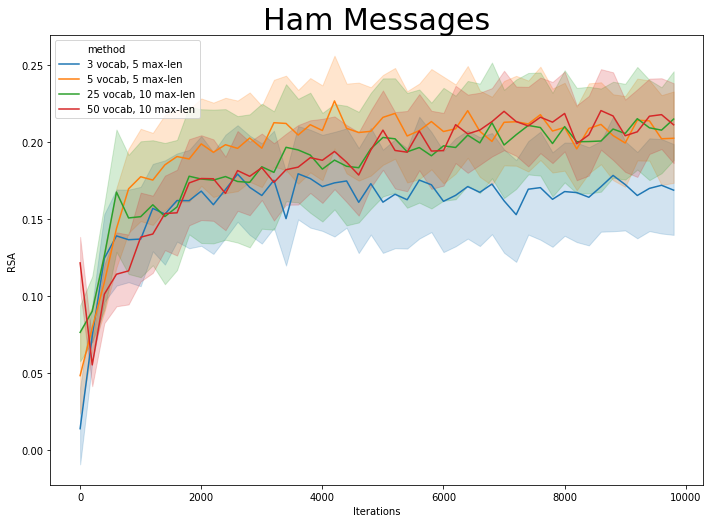

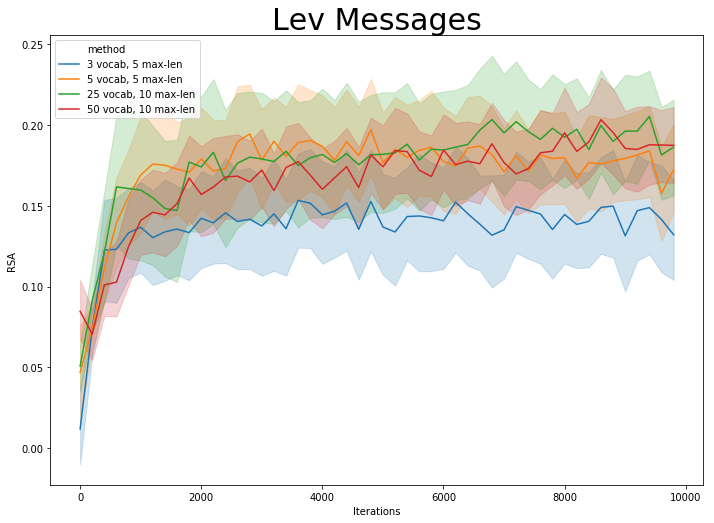

In [7]:
RSA_0 = pickle.load(open(f'runs/lstm_max_len_5_vocab_3_attr_5/rsa_analysis.pkl', 'rb'))
RSA_1 = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_attr_5/rsa_analysis.pkl', 'rb'))
RSA_2 = pickle.load(open(f'runs/lstm_max_len_10_vocab_25_attr_5/rsa_analysis.pkl', 'rb'))
RSA_3 = pickle.load(open(f'runs/lstm_max_len_10_vocab_50_attr_5/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {
                '3 vocab, 5 max-len': RSA_0,
                '5 vocab, 5 max-len': RSA_1,
                '25 vocab, 10 max-len': RSA_2,
                '50 vocab, 10 max-len': RSA_3
               }

for k in RSA_BASELINE:
    if k == "ham_messages" or k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k)

The results show that environmental pressures in the form of vocabulary sizes and max lengths do not seem to affect the message structure a lot. Only on the very small vocabulary size the results seem to differ slightly.

# Part 2: Mapping network

As a second experiment, we will use a mapping network to translate languages. Should the agents have similar structure within their languages, they should be able to solve the task using translated messages from other languages. Say we have languages A and B, both created and used by a different pair of sender and receiver. If the agents use dissimilar structure, the translation deducted from the message of sender A will create a sequence that is unfamiliar to receiver B. Hence, receiver B will be unable to perform the task properly.

Need to know whether the structure is encapsulated in the mapping network or not.

# Part 3: Generalization

As a final experiment, we will try and find whether there exist any differences between the extent to which agents of different language are able to generalize. While we expect to find that all agents are able to generalize to a certain extent, some might be better able to generalize than others. This is based on the fact that agents seem to use completely different structures within their language, as is appointed by the problem area RSA figure. If structures are similar between languages, we will likely find that agents are able to generalize to similar extent. Differences in performance on new (not seen before) samples will indicate the degree of which structure in the created languages will differ.